# Необходимые библиотеки

In [13]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
import numpy as np
import importlib
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import segmentation_models_pytorch as smp
from transformers import SegformerForSemanticSegmentation
from utils import functions
from models import unet
from models import unetmod
from models import linknet
from models import deeplabv3
importlib.reload(functions)
importlib.reload(unet)
importlib.reload(unetmod)
importlib.reload(linknet)
importlib.reload(deeplabv3)

<module 'models.deeplabv3' from 'C:\\Users\\Raindow\\Desktop\\СПБГУ\\models\\deeplabv3.py'>

# Первая модель - U-Net

## Конфигурация

In [9]:
# Конфигурация
DATA_PATH = "dataset"
BATCH_SIZE = 16
EPOCHS = 100
LR = 0.001
IMG_SIZE = 256
NUM_MODELS = 5
MODEL_PART = 0

## Класс, описывающий датасет

In [10]:
# Dataset
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))

        self.empty_indices = []
        self.non_empty_indices = []

        for idx, img_name in enumerate(self.images):
            mask_path = os.path.join(self.mask_dir, img_name)
            mask = np.array(Image.open(mask_path).convert("L"))
            if np.all(mask == 0):
                self.empty_indices.append(idx)
            else:
                self.non_empty_indices.append(idx)

        print(f"Total: {len(self.images)} images")
        print(f"Mask statistics: {len(self.empty_indices)} empty, {len(self.non_empty_indices)} non-empty")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

## Подготовка данных

In [11]:
# Аугментация
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
])

# Загрузка полного датасета
full_dataset = SegmentationDataset(
    image_dir=os.path.join(DATA_PATH, "images"),
    mask_dir=os.path.join(DATA_PATH, "masks"),
    transform=transform
)

# Создание сбалансированного списка индексов
empty = full_dataset.empty_indices
non_empty = full_dataset.non_empty_indices
random.shuffle(empty)
random.shuffle(non_empty)

min_count = min(len(empty), len(non_empty))
balanced_indices = empty + non_empty
random.shuffle(balanced_indices)

# Разделение на обучающую и тестовую выборку
split_idx = int(0.8 * len(balanced_indices))
train_indices = balanced_indices[:split_idx]
test_indices = balanced_indices[split_idx:]

# Разделение на части для ансамбля
part_size = len(train_indices) // NUM_MODELS
start_idx = MODEL_PART * part_size
end_idx = start_idx + part_size if MODEL_PART != NUM_MODELS - 1 else len(train_indices)
train_part_indices = train_indices[start_idx:end_idx]

train_subset = Subset(full_dataset, train_part_indices)
test_subset = Subset(full_dataset, test_indices)

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE)


Total: 17408 images
Mask statistics: 13435 empty, 3973 non-empty


## Обучение U-net в ансамбле

In [6]:
# Обучение
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = unet.UNetSM(in_channels=3, out_channels=1)

# Создаем модель с дополнительными слоями
print(device)
modified_model = model.to(device)
pos_weight = torch.tensor([10.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(modified_model.parameters(), lr=LR, weight_decay=1e-5)

train_losses, test_losses, ious, dices = [], [], [], []
best_iou = -1

for epoch in range(EPOCHS):
    modified_model.train()
    epoch_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = modified_model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    modified_model.eval()
    test_loss = 0
    epoch_ious, epoch_dices = [], []
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = modified_model(images)
            test_loss += criterion(outputs, masks).item()
            batch_iou, batch_dice = functions.calculate_metrics(outputs, masks)
            epoch_ious.append(batch_iou)
            epoch_dices.append(batch_dice)

    avg_iou = np.mean(epoch_ious)
    avg_dice = np.mean(epoch_dices)
    avg_test_loss = test_loss / len(test_loader)

    train_losses.append(epoch_loss / len(train_loader))
    test_losses.append(avg_test_loss)
    ious.append(avg_iou)
    dices.append(avg_dice)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f}")
    print(f"IoU: {ious[-1]:.4f} | Dice: {dices[-1]:.4f}")
    print("------------------------")
    if avg_iou > best_iou:
        best_iou = avg_iou
        torch.save(modified_model.state_dict(), "u-net_ensemble.pth")
        print(f"Best modified_model saved at epoch {epoch+1} with IoU: {avg_iou:.4f}")

cuda
Epoch 1/100
Train Loss: 0.9132 | Test Loss: 0.8717
IoU: 0.7803 | Dice: 0.7803
------------------------
Best modified_model saved at epoch 1 with IoU: 0.7803
Epoch 2/100
Train Loss: 0.8682 | Test Loss: 0.8619
IoU: 0.7443 | Dice: 0.7449
------------------------
Epoch 3/100
Train Loss: 0.8651 | Test Loss: 0.8599
IoU: 0.7803 | Dice: 0.7803
------------------------
Epoch 4/100
Train Loss: 0.8631 | Test Loss: 0.8718
IoU: 0.7800 | Dice: 0.7800
------------------------
Epoch 5/100
Train Loss: 0.8630 | Test Loss: 0.8600
IoU: 0.7803 | Dice: 0.7803
------------------------
Epoch 6/100
Train Loss: 0.8608 | Test Loss: 0.8585
IoU: 0.7714 | Dice: 0.7714
------------------------
Epoch 7/100
Train Loss: 0.8599 | Test Loss: 0.8581
IoU: 0.7609 | Dice: 0.7612
------------------------
Epoch 8/100
Train Loss: 0.8615 | Test Loss: 0.8595
IoU: 0.7503 | Dice: 0.7507
------------------------
Epoch 9/100
Train Loss: 0.8725 | Test Loss: 0.8590
IoU: 0.7803 | Dice: 0.7803
------------------------
Epoch 10/100
T

In [7]:
torch.save(modified_model.state_dict(), "u-net_ensemble.pth")

## Графики U-Net

## Test/train losses

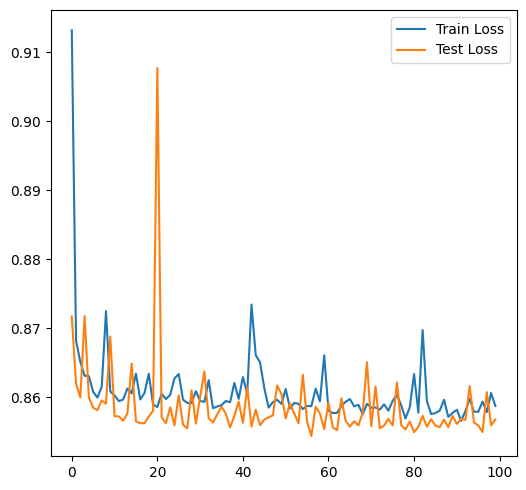

In [8]:
# Графики
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.tight_layout()
plt.show()

## IoU

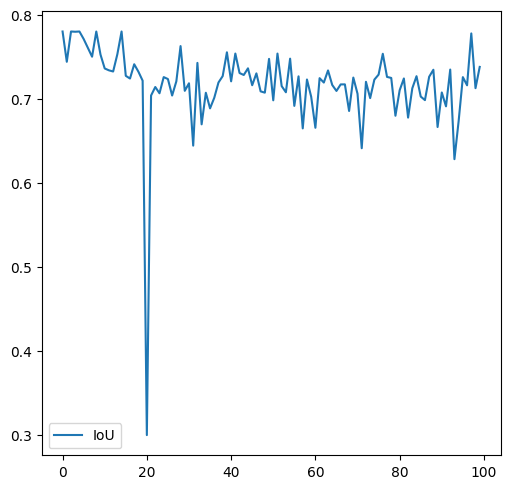

In [9]:
plt.figure(figsize=(15, 5))
plt.subplot(132)
plt.plot(ious, label='IoU')
plt.legend()
plt.tight_layout()
plt.show()

## Dice coef

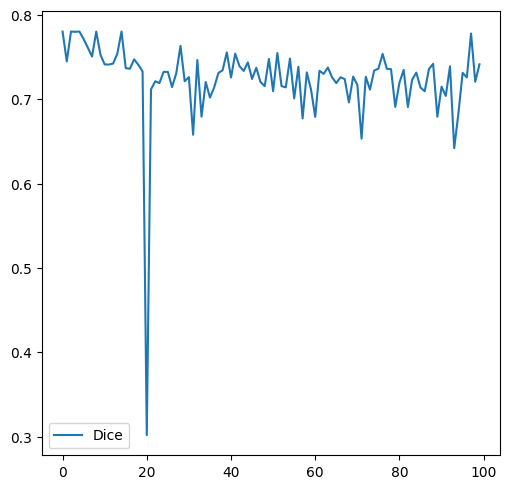

In [10]:
plt.figure(figsize=(15, 5))
plt.subplot(133)
plt.plot(dices, label='Dice')
plt.legend()
plt.tight_layout()
plt.show()

# Вторая модель - SegFormer

## Конфигурация

In [14]:
# Конфигурация
DATA_PATH = "dataset"
BATCH_SIZE = 16
EPOCHS = 100
LR = 0.001
IMG_SIZE = 256
NUM_MODELS = 5
MODEL_PART = 1

## Класс, описывающий датасет

In [15]:
# Dataset
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))

        self.empty_indices = []
        self.non_empty_indices = []

        for idx, img_name in enumerate(self.images):
            mask_path = os.path.join(self.mask_dir, img_name)
            mask = np.array(Image.open(mask_path).convert("L"))
            if np.all(mask == 0):
                self.empty_indices.append(idx)
            else:
                self.non_empty_indices.append(idx)

        print(f"Total: {len(self.images)} images")
        print(f"Mask statistics: {len(self.empty_indices)} empty, {len(self.non_empty_indices)} non-empty")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

## Подготовка данных

In [16]:
# Аугментация
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
])

# Загрузка полного датасета
full_dataset = SegmentationDataset(
    image_dir=os.path.join(DATA_PATH, "images"),
    mask_dir=os.path.join(DATA_PATH, "masks"),
    transform=transform
)

# Создание сбалансированного списка индексов
empty = full_dataset.empty_indices
non_empty = full_dataset.non_empty_indices
random.shuffle(empty)
random.shuffle(non_empty)

min_count = min(len(empty), len(non_empty))
balanced_indices = empty + non_empty
random.shuffle(balanced_indices)

# Разделение на обучающую и тестовую выборку
split_idx = int(0.8 * len(balanced_indices))
train_indices = balanced_indices[:split_idx]
test_indices = balanced_indices[split_idx:]

# Разделение на части для ансамбля
part_size = len(train_indices) // NUM_MODELS
start_idx = MODEL_PART * part_size
end_idx = start_idx + part_size if MODEL_PART != NUM_MODELS - 1 else len(train_indices)
train_part_indices = train_indices[start_idx:end_idx]

train_subset = Subset(full_dataset, train_part_indices)
test_subset = Subset(full_dataset, test_indices)

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE)

Total: 17408 images
Mask statistics: 13435 empty, 3973 non-empty


## Обучение SegFormer в ансамбле

In [17]:
# Обучение
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Использование предобученной модели SegFormer
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b4", num_labels=1)

# Перенос модели на устройство
print(device)
modified_model = model.to(device)
pos_weight = torch.tensor([10.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(modified_model.parameters(), lr=LR, weight_decay=1e-5)

train_losses, test_losses, ious, dices = [], [], [], []
best_iou = -1

for epoch in range(EPOCHS):
    modified_model.train()
    epoch_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = modified_model(images).logits

        # Увеличиваем размер выходных данных до размера масок
        outputs = torch.nn.functional.interpolate(
            outputs, size=(IMG_SIZE, IMG_SIZE), mode="bilinear", align_corners=False
        )

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    modified_model.eval()
    test_loss = 0
    epoch_ious, epoch_dices = [], []
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = modified_model(images).logits

            # Увеличиваем размер выходных данных до размера масок
            outputs = torch.nn.functional.interpolate(
                outputs, size=(IMG_SIZE, IMG_SIZE), mode="bilinear", align_corners=False
            )

            test_loss += criterion(outputs, masks).item()
            batch_iou, batch_dice = functions.calculate_metrics(outputs, masks)
            epoch_ious.append(batch_iou)
            epoch_dices.append(batch_dice)

    avg_iou = np.mean(epoch_ious)
    avg_dice = np.mean(epoch_dices)
    avg_test_loss = test_loss / len(test_loader)

    train_losses.append(epoch_loss / len(train_loader))
    test_losses.append(avg_test_loss)
    ious.append(avg_iou)
    dices.append(avg_dice)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f}")
    print(f"IoU: {ious[-1]:.4f} | Dice: {dices[-1]:.4f}")
    print("------------------------")
    if avg_iou > best_iou:
        best_iou = avg_iou
        torch.save(modified_model.state_dict(), "segformer_ensemble.pth")
        print(f"Best model saved at epoch {epoch+1} with IoU: {avg_iou:.4f}")

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b4 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda
Epoch 1/100
Train Loss: 0.5412 | Test Loss: 0.5309
IoU: 0.7286 | Dice: 0.7356
------------------------
Best model saved at epoch 1 with IoU: 0.7286
Epoch 2/100
Train Loss: 0.4774 | Test Loss: 0.9677
IoU: 0.1004 | Dice: 0.1188
------------------------
Epoch 3/100
Train Loss: 0.4707 | Test Loss: 0.7208
IoU: 0.7599 | Dice: 0.7599
------------------------
Best model saved at epoch 3 with IoU: 0.7599
Epoch 4/100
Train Loss: 0.4627 | Test Loss: 0.4693
IoU: 0.7420 | Dice: 0.7438
------------------------
Epoch 5/100
Train Loss: 0.4441 | Test Loss: 0.4937
IoU: 0.6945 | Dice: 0.6951
------------------------
Epoch 6/100
Train Loss: 0.4451 | Test Loss: 0.5605
IoU: 0.7317 | Dice: 0.7358
------------------------
Epoch 7/100
Train Loss: 0.4469 | Test Loss: 0.4601
IoU: 0.7599 | Dice: 0.7599
------------------------
Epoch 8/100
Train Loss: 0.4324 | Test Loss: 0.5034
IoU: 0.6484 | Dice: 0.6620
------------------------
Epoch 9/100
Train Loss: 0.4423 | Test Loss: 0.4989
IoU: 0.7158 | Dice: 0.7242
---

In [ ]:
torch.save(modified_model.state_dict(), "segformer_ensemble.pth")

## Графики SegFormer

## Test/train losses

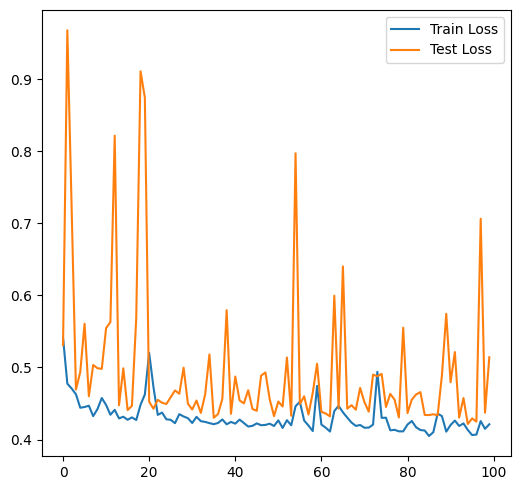

In [18]:
# Графики
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.tight_layout()
plt.show()

## IoU

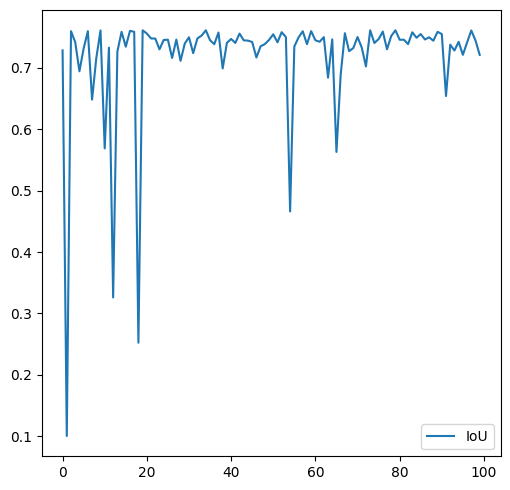

In [19]:
plt.figure(figsize=(15, 5))
plt.subplot(132)
plt.plot(ious, label='IoU')
plt.legend()
plt.tight_layout()
plt.show()

## Dice coef

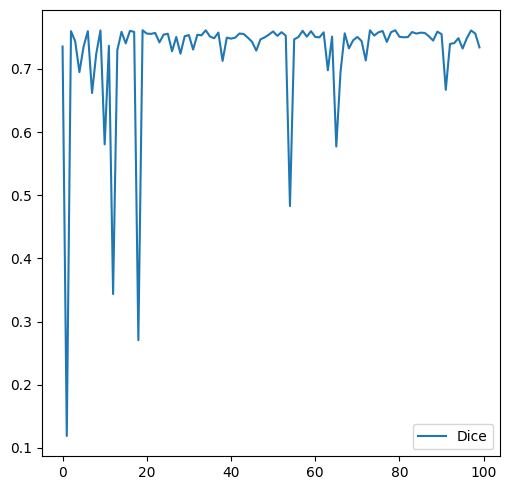

In [20]:
plt.figure(figsize=(15, 5))
plt.subplot(133)
plt.plot(dices, label='Dice')
plt.legend()
plt.tight_layout()
plt.show()

# Третья модель - U-net mod.

## Конфигурация

In [3]:
# Конфигурация
DATA_PATH = "dataset"
BATCH_SIZE = 16
EPOCHS = 100
LR = 0.001
IMG_SIZE = 256
NUM_MODELS = 5
MODEL_PART = 2

## Класс, описываюший датасет

In [4]:
# Dataset
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))

        self.empty_indices = []
        self.non_empty_indices = []

        for idx, img_name in enumerate(self.images):
            mask_path = os.path.join(self.mask_dir, img_name)
            mask = np.array(Image.open(mask_path).convert("L"))
            if np.all(mask == 0):
                self.empty_indices.append(idx)
            else:
                self.non_empty_indices.append(idx)

        print(f"Total: {len(self.images)} images")
        print(f"Mask statistics: {len(self.empty_indices)} empty, {len(self.non_empty_indices)} non-empty")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

## Подготовка данных

In [5]:
# Аугментация
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
])

# Загрузка полного датасета
full_dataset = SegmentationDataset(
    image_dir=os.path.join(DATA_PATH, "images"),
    mask_dir=os.path.join(DATA_PATH, "masks"),
    transform=transform
)

# Создание сбалансированного списка индексов
empty = full_dataset.empty_indices
non_empty = full_dataset.non_empty_indices
random.shuffle(empty)
random.shuffle(non_empty)

min_count = min(len(empty), len(non_empty))
balanced_indices = empty + non_empty
random.shuffle(balanced_indices)

# Разделение на обучающую и тестовую выборку
split_idx = int(0.8 * len(balanced_indices))
train_indices = balanced_indices[:split_idx]
test_indices = balanced_indices[split_idx:]

# Разделение на части для ансамбля
part_size = len(train_indices) // NUM_MODELS
start_idx = MODEL_PART * part_size
end_idx = start_idx + part_size if MODEL_PART != NUM_MODELS - 1 else len(train_indices)
train_part_indices = train_indices[start_idx:end_idx]

train_subset = Subset(full_dataset, train_part_indices)
test_subset = Subset(full_dataset, test_indices)

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE)

Total: 17408 images
Mask statistics: 13435 empty, 3973 non-empty


## Обучение U-Net mod. в ансамбле

In [6]:
# Обучение
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = unetmod.UNetSM(in_channels=3, out_channels=1)

# Создаем модель с дополнительными слоями
print(device)
modified_model = model.to(device)
pos_weight = torch.tensor([10.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(modified_model.parameters(), lr=LR, weight_decay=1e-5)

train_losses, test_losses, ious, dices = [], [], [], []
best_iou = -1

for epoch in range(EPOCHS):
    modified_model.train()
    epoch_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = modified_model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    modified_model.eval()
    test_loss = 0
    epoch_ious, epoch_dices = [], []
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = modified_model(images)
            test_loss += criterion(outputs, masks).item()
            
            batch_iou, batch_dice = functions.calculate_metrics(outputs, masks)
            epoch_ious.append(batch_iou)
            epoch_dices.append(batch_dice)

    avg_iou = np.mean(epoch_ious)
    avg_dice = np.mean(epoch_dices)
    avg_test_loss = test_loss / len(test_loader)

    train_losses.append(epoch_loss / len(train_loader))
    test_losses.append(avg_test_loss)
    ious.append(avg_iou)
    dices.append(avg_dice)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f}")
    print(f"IoU: {ious[-1]:.4f} | Dice: {dices[-1]:.4f}")
    print("------------------------")
    if avg_iou > best_iou:
        best_iou = avg_iou
        torch.save(modified_model.state_dict(), "u-net_Mod_ensemble.pth")
        print(f"Best modified_model saved at epoch {epoch+1} with IoU: {avg_iou:.4f}")



cuda
Epoch 1/100
Train Loss: 0.5455 | Test Loss: 0.5322
IoU: 0.5487 | Dice: 0.5618
------------------------
Best modified_model saved at epoch 1 with IoU: 0.5487
Epoch 2/100
Train Loss: 0.5042 | Test Loss: 0.4475
IoU: 0.7685 | Dice: 0.7685
------------------------
Best modified_model saved at epoch 2 with IoU: 0.7685
Epoch 3/100
Train Loss: 0.4957 | Test Loss: 0.4542
IoU: 0.6802 | Dice: 0.6928
------------------------
Epoch 4/100
Train Loss: 0.5007 | Test Loss: 0.4411
IoU: 0.7158 | Dice: 0.7190
------------------------
Epoch 5/100
Train Loss: 0.4900 | Test Loss: 0.4485
IoU: 0.7165 | Dice: 0.7209
------------------------
Epoch 6/100
Train Loss: 0.4912 | Test Loss: 0.4435
IoU: 0.7298 | Dice: 0.7322
------------------------
Epoch 7/100
Train Loss: 0.5073 | Test Loss: 0.4412
IoU: 0.7150 | Dice: 0.7187
------------------------
Epoch 8/100
Train Loss: 0.5318 | Test Loss: 0.4450
IoU: 0.7139 | Dice: 0.7234
------------------------
Epoch 9/100
Train Loss: 0.4940 | Test Loss: 0.4395
IoU: 0.7064 

In [7]:
torch.save(modified_model.state_dict(), "u-net_Mod_ensemble.pth")

## Графики U-Net mod.

## Test/train losses

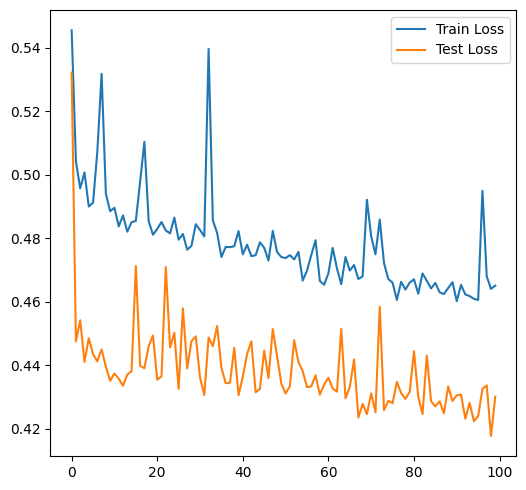

In [8]:
# Графики
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.tight_layout()
plt.show()

## IoU

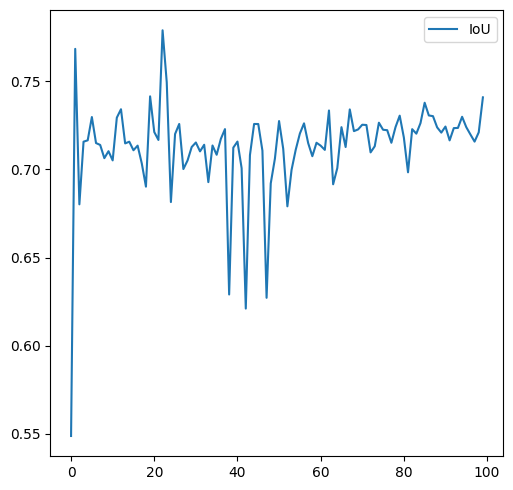

In [9]:
plt.figure(figsize=(15, 5))
plt.subplot(132)
plt.plot(ious, label='IoU')
plt.legend()
plt.tight_layout()
plt.show()

## Dice coef

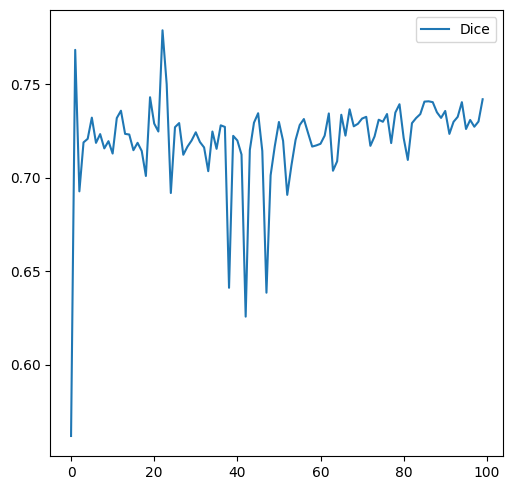

In [10]:
plt.figure(figsize=(15, 5))
plt.subplot(133)
plt.plot(dices, label='Dice')
plt.legend()
plt.tight_layout()
plt.show()

# Четвертая модель - Linknet

## Конфигурация

In [15]:
# Конфигурация
DATA_PATH = "dataset"
BATCH_SIZE = 16
EPOCHS = 100
LR = 0.001
IMG_SIZE = 256
NUM_MODELS = 5
MODEL_PART = 3

## Класс, описывающий датасет

In [16]:
# Dataset
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))

        self.empty_indices = []
        self.non_empty_indices = []

        for idx, img_name in enumerate(self.images):
            mask_path = os.path.join(self.mask_dir, img_name)
            mask = np.array(Image.open(mask_path).convert("L"))
            if np.all(mask == 0):
                self.empty_indices.append(idx)
            else:
                self.non_empty_indices.append(idx)

        print(f"Total: {len(self.images)} images")
        print(f"Mask statistics: {len(self.empty_indices)} empty, {len(self.non_empty_indices)} non-empty")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

## Подготовка данных

In [17]:
# Аугментация
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
])

# Загрузка полного датасета
full_dataset = SegmentationDataset(
    image_dir=os.path.join(DATA_PATH, "images"),
    mask_dir=os.path.join(DATA_PATH, "masks"),
    transform=transform
)

# Создание сбалансированного списка индексов
empty = full_dataset.empty_indices
non_empty = full_dataset.non_empty_indices
random.shuffle(empty)
random.shuffle(non_empty)

min_count = min(len(empty), len(non_empty))
balanced_indices = empty + non_empty
random.shuffle(balanced_indices)

# Разделение на обучающую и тестовую выборку
split_idx = int(0.8 * len(balanced_indices))
train_indices = balanced_indices[:split_idx]
test_indices = balanced_indices[split_idx:]

# Разделение на части для ансамбля
part_size = len(train_indices) // NUM_MODELS
start_idx = MODEL_PART * part_size
end_idx = start_idx + part_size if MODEL_PART != NUM_MODELS - 1 else len(train_indices)
train_part_indices = train_indices[start_idx:end_idx]

train_subset = Subset(full_dataset, train_part_indices)
test_subset = Subset(full_dataset, test_indices)

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE)

Total: 17408 images
Mask statistics: 13435 empty, 3973 non-empty


## Обучение Linknet в ансамбле

In [19]:
# Создаем модель с дополнительными слоями
print(device)

model = linknet.LinkNet(num_classes=1, in_channels=3).to(device)

modified_model = model.to(device)
pos_weight = torch.tensor([10.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(modified_model.parameters(), lr=LR, weight_decay=1e-5)

train_losses, test_losses, ious, dices = [], [], [], []
best_iou = -1

for epoch in range(EPOCHS):
    modified_model.train()
    epoch_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = modified_model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    modified_model.eval()
    test_loss = 0
    epoch_ious, epoch_dices = [], []
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = modified_model(images)
            test_loss += criterion(outputs, masks).item()
            batch_iou, batch_dice = functions.calculate_metrics(outputs, masks)
            epoch_ious.append(batch_iou)
            epoch_dices.append(batch_dice)

    avg_iou = np.mean(epoch_ious)
    avg_dice = np.mean(epoch_dices)
    avg_test_loss = test_loss / len(test_loader)

    train_losses.append(epoch_loss / len(train_loader))
    test_losses.append(avg_test_loss)
    ious.append(avg_iou)
    dices.append(avg_dice)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f}")
    print(f"IoU: {ious[-1]:.4f} | Dice: {dices[-1]:.4f}")
    print("------------------------")
    if avg_iou > best_iou:
        best_iou = avg_iou
        torch.save(modified_model.state_dict(), "Linknet_ensemble.pth")
        print(f"Best modified_model saved at epoch {epoch+1} with IoU: {avg_iou:.4f}")

cuda
Epoch 1/100
Train Loss: 0.5329 | Test Loss: 0.5097
IoU: 0.7126 | Dice: 0.7136
------------------------
Best modified_model saved at epoch 1 with IoU: 0.7126
Epoch 2/100
Train Loss: 0.4692 | Test Loss: 0.4982
IoU: 0.7157 | Dice: 0.7249
------------------------
Best modified_model saved at epoch 2 with IoU: 0.7157
Epoch 3/100
Train Loss: 0.4636 | Test Loss: 0.5401
IoU: 0.6695 | Dice: 0.6825
------------------------
Epoch 4/100
Train Loss: 0.4491 | Test Loss: 0.4440
IoU: 0.7049 | Dice: 0.7138
------------------------
Epoch 5/100
Train Loss: 0.4591 | Test Loss: 0.4584
IoU: 0.6859 | Dice: 0.6991
------------------------
Epoch 6/100
Train Loss: 0.4564 | Test Loss: 0.4636
IoU: 0.6916 | Dice: 0.7041
------------------------
Epoch 7/100
Train Loss: 0.4668 | Test Loss: 0.5129
IoU: 0.7139 | Dice: 0.7219
------------------------
Epoch 8/100
Train Loss: 0.4561 | Test Loss: 0.7871
IoU: 0.7109 | Dice: 0.7223
------------------------
Epoch 9/100
Train Loss: 0.4461 | Test Loss: 0.4465
IoU: 0.7016 

In [20]:
torch.save(modified_model.state_dict(), "Linknet_ensemble.pth")

## Графики Linknet

## Test/train losses

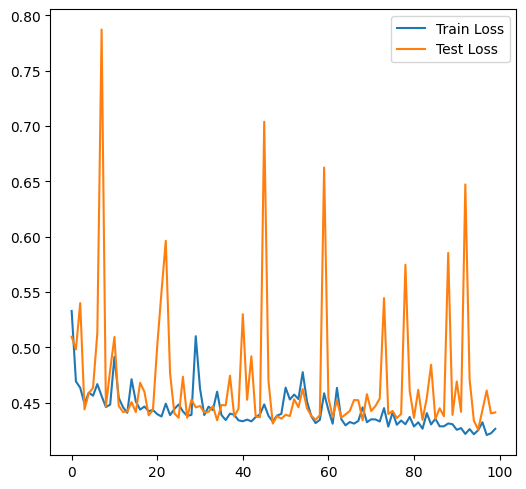

In [21]:
# Графики
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.tight_layout()
plt.show()

## IoU

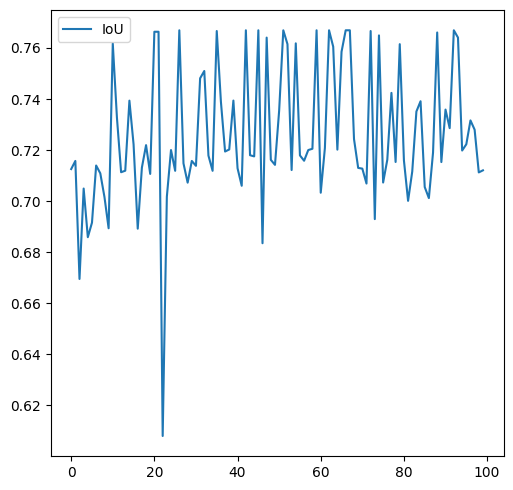

In [22]:
plt.figure(figsize=(15, 5))
plt.subplot(132)
plt.plot(ious, label='IoU')
plt.legend()
plt.tight_layout()
plt.show()

## Dice coef

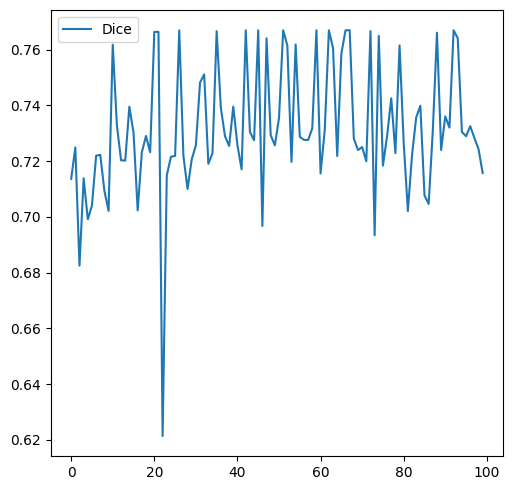

In [23]:
plt.figure(figsize=(15, 5))
plt.subplot(133)
plt.plot(dices, label='Dice')
plt.legend()
plt.tight_layout()
plt.show()

# Пятая модель - DeepLabV3+

## Конфигурация

In [22]:
# Конфигурация
DATA_PATH = "dataset"
BATCH_SIZE = 16
EPOCHS = 100
LR = 0.001
IMG_SIZE = 256
NUM_MODELS = 5
MODEL_PART = 4

## Класс, описывающий датасет

In [6]:
# Dataset
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))

        self.empty_indices = []
        self.non_empty_indices = []

        for idx, img_name in enumerate(self.images):
            mask_path = os.path.join(self.mask_dir, img_name)
            mask = np.array(Image.open(mask_path).convert("L"))
            if np.all(mask == 0):
                self.empty_indices.append(idx)
            else:
                self.non_empty_indices.append(idx)

        print(f"Total: {len(self.images)} images")
        print(f"Mask statistics: {len(self.empty_indices)} empty, {len(self.non_empty_indices)} non-empty")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

## Подготовка данных

In [7]:
# Аугментация
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
])

# Загрузка полного датасета
full_dataset = SegmentationDataset(
    image_dir=os.path.join(DATA_PATH, "images"),
    mask_dir=os.path.join(DATA_PATH, "masks"),
    transform=transform
)

# Создание сбалансированного списка индексов
empty = full_dataset.empty_indices
non_empty = full_dataset.non_empty_indices
random.shuffle(empty)
random.shuffle(non_empty)

min_count = min(len(empty), len(non_empty))
balanced_indices = empty + non_empty
random.shuffle(balanced_indices)

# Разделение на обучающую и тестовую выборку
split_idx = int(0.8 * len(balanced_indices))
train_indices = balanced_indices[:split_idx]
test_indices = balanced_indices[split_idx:]

# Разделение на части для ансамбля
part_size = len(train_indices) // NUM_MODELS
start_idx = MODEL_PART * part_size
end_idx = start_idx + part_size if MODEL_PART != NUM_MODELS - 1 else len(train_indices)
train_part_indices = train_indices[start_idx:end_idx]

train_subset = Subset(full_dataset, train_part_indices)
test_subset = Subset(full_dataset, test_indices)

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE)

Total: 17408 images
Mask statistics: 13435 empty, 3973 non-empty


## Обучение DeepLabV3+ в ансамбле

In [8]:
# Обучение
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = deeplabv3.DeepLabV3PlusResNet50(num_classes=1).to(device)
pos_weight = torch.tensor([10.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)

train_losses, test_losses, ious, dices = [], [], [], []
best_iou = -1

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    model.eval()
    test_loss = 0
    epoch_ious, epoch_dices = [], []
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            test_loss += criterion(outputs, masks).item()
            batch_iou, batch_dice = functions.calculate_metrics(outputs, masks)
            epoch_ious.append(batch_iou)
            epoch_dices.append(batch_dice)

    avg_iou = np.mean(epoch_ious)
    avg_dice = np.mean(epoch_dices)
    avg_test_loss = test_loss / len(test_loader)

    train_losses.append(epoch_loss / len(train_loader))
    test_losses.append(avg_test_loss)
    ious.append(avg_iou)
    dices.append(avg_dice)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f}")
    print(f"IoU: {ious[-1]:.4f} | Dice: {dices[-1]:.4f}")
    print("------------------------")
    if avg_iou > best_iou:
        best_iou = avg_iou
        torch.save(model.state_dict(), "deeplabv3+_ensemble.pth")
        print(f"Best model saved at epoch {epoch+1} with IoU: {avg_iou:.4f}")

C:\Users\Raindow\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Raindow\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/100
Train Loss: 0.5193 | Test Loss: 0.5143
IoU: 0.7750 | Dice: 0.7750
------------------------
Best model saved at epoch 1 with IoU: 0.7750
Epoch 2/100
Train Loss: 0.4963 | Test Loss: 0.4994
IoU: 0.7753 | Dice: 0.7753
------------------------
Best model saved at epoch 2 with IoU: 0.7753
Epoch 3/100
Train Loss: 0.4842 | Test Loss: 0.4375
IoU: 0.7731 | Dice: 0.7732
------------------------
Epoch 4/100
Train Loss: 0.4826 | Test Loss: 0.4890
IoU: 0.7753 | Dice: 0.7753
------------------------
Epoch 5/100
Train Loss: 0.4763 | Test Loss: 0.4521
IoU: 0.7647 | Dice: 0.7672
------------------------
Epoch 6/100
Train Loss: 0.4848 | Test Loss: 1.5731
IoU: 0.7753 | Dice: 0.7753
------------------------
Epoch 7/100
Train Loss: 0.4745 | Test Loss: 0.4691
IoU: 0.7302 | Dice: 0.7422
------------------------
Epoch 8/100
Train Loss: 0.4693 | Test Loss: 1.1588
IoU: 0.7753 | Dice: 0.7753
------------------------
Epoch 9/100
Train Loss: 0.4660 | Test Loss: 0.4504
IoU: 0.7753 | Dice: 0.7753
--------

In [9]:
torch.save(model.state_dict(), "deeplabv3+_ensemble.pth")

## Графики DeepLabV3+

## Train/test losses

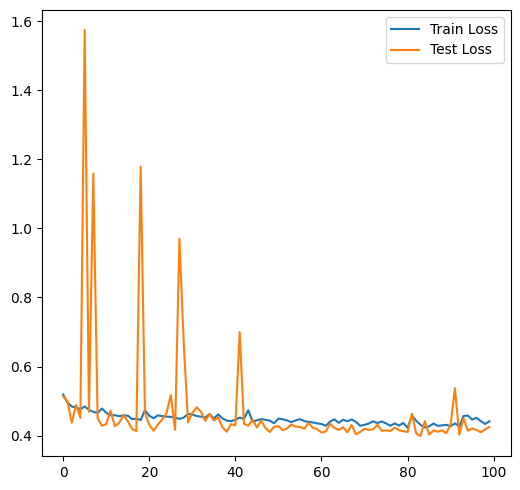

In [10]:
# Графики
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.tight_layout()
plt.show()

## IoU

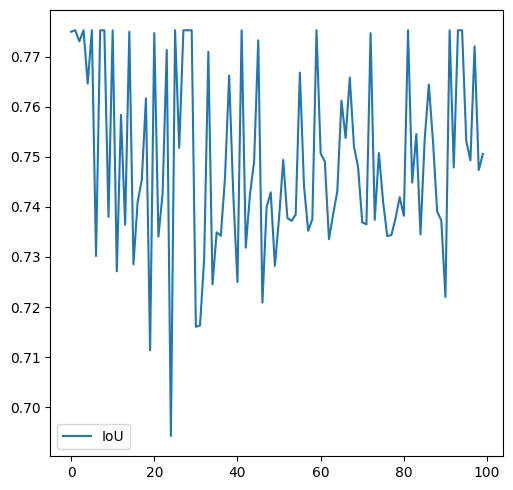

In [11]:
plt.figure(figsize=(15, 5))
plt.subplot(132)
plt.plot(ious, label='IoU')
plt.legend()
plt.tight_layout()
plt.show()

## Dice coef

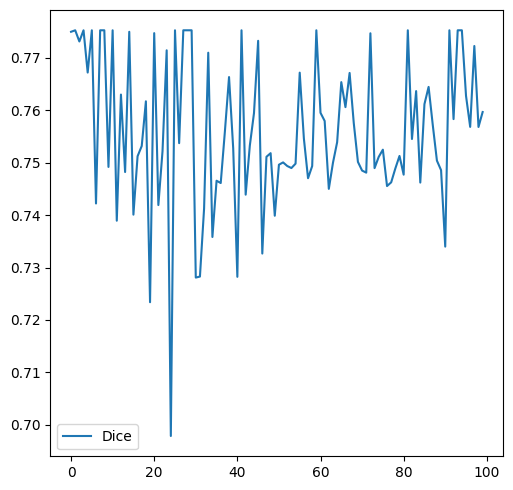

In [12]:
plt.figure(figsize=(15, 5))
plt.subplot(133)
plt.plot(dices, label='Dice')
plt.legend()
plt.tight_layout()
plt.show()

# Усредненный ансамбль

## Загрузка сохраненных моделей

## U-Net

In [17]:
# Загрузка сохранённых моделей
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
u_net_model = unet.UNetSM(in_channels=3, out_channels=1).to(device)
u_net_model.load_state_dict(torch.load("u-net_ensemble.pth"))
u_net_model.eval()

UNetSM(
  (encoder1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_siz

## SegFormer

In [3]:
segformer_model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b4", num_labels=1).to(device)
segformer_model.load_state_dict(torch.load("segformer_ensemble.pth"))
segformer_model.eval()

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b4 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

## U-net mod.

In [18]:
u_net_mod_model = unetmod.UNetSM(in_channels=3, out_channels=1).to(device)
u_net_mod_model.load_state_dict(torch.load("u-net_Mod_ensemble.pth"))
u_net_mod_model.eval()

UNetSM(
  (encoder): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchN

## LinkNet

In [7]:
linknet_model = linknet.LinkNet(num_classes=1, in_channels=3).to(device)
linknet_model.load_state_dict(torch.load("linknet_ensemble.pth"))
linknet_model.eval()

C:\Users\Raindow\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Raindow\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


LinkNet(
  (in_block): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (encoder1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kerne

## Deeplab V3+

In [8]:
deeplab_model = deeplabv3.DeepLabV3PlusResNet50(num_classes=1).to(device)
deeplab_model.load_state_dict(torch.load("deeplabv3+_ensemble.pth"))
deeplab_model.eval()

C:\Users\Raindow\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DeepLabV3PlusResNet50(
  (layer0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 

## Оценка ансамбля

In [24]:
# Оценка ансамбля
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE)

ious, dices = [], []

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Evaluating Ensemble"):
        images, masks = images.to(device), masks.to(device)

        unet_outputs = u_net_model(images)

        segformer_outputs = segformer_model(images).logits
        segformer_outputs = torch.nn.functional.interpolate(
            segformer_outputs, size=(IMG_SIZE, IMG_SIZE), mode="bilinear", align_corners=False
        )

        deeplab_outputs = deeplab_model(images)

        unet_mod_outputs = u_net_mod_model(images)

        linknet_outputs = linknet_model(images)

        # Усреднение предсказаний всех трех моделей
        ensemble_outputs = (torch.sigmoid(unet_outputs) +
                          torch.sigmoid(segformer_outputs) +
                          torch.sigmoid(deeplab_outputs) +
                          torch.sigmoid(unet_mod_outputs) +
                          torch.sigmoid(linknet_outputs)) / 5

        # Расчёт метрик
        batch_iou, batch_dice = functions.calculate_metrics(ensemble_outputs, masks)
        ious.append(batch_iou)
        dices.append(batch_dice)

# Итоговые метрики
mean_iou = np.mean(ious)
mean_dice = np.mean(dices)

print(f"Ensemble Metrics:")
print(f"IoU: {mean_iou:.4f}")
print(f"Dice: {mean_dice:.4f}")

Evaluating Ensemble: 100%|███████████████████████████████████████████████████████████| 218/218 [01:14<00:00,  2.92it/s]

Ensemble Metrics:
IoU: 0.7367
Dice: 0.7411
